## 17 - Collaborative map
>Collaborate with others on a single map. For today’s challenge, team up! Whether you work with one person or several, the idea is to combine your efforts on a single map. 🤝🗺️

In [ ]:
from glob import glob
import matplotlib.pyplot as plt
import geopandas as gpd
import fitdecode
import pandas as pd
from typing import Dict, Union, Optional
from datetime import datetime
import pandas as pd
from shapely import LineString
from matplotlib_scalebar.scalebar import ScaleBar
import matplotlib.patches as patches

In [ ]:
# from: https://github.com/dodo-saba/fit2gpx/
# extends fitdecode and wranges it into the geodataframe
def get_fit_points(frame: fitdecode.records.FitDataMessage) \
            -> Optional[Dict[str, Union[float, int, str, datetime]]]:
        """Extract some data from an FIT frame representing a track point and return it as a dict.
        """
        # Step 0: Initialise data output
        data: Dict[str, Union[float, int, str, datetime]] = {}

        # Step 1: Obtain frame lat and long and convert it from integer to degree (if frame has lat and long data)
        if not (frame.has_field('position_lat') and frame.has_field('position_long')):
            # Frame does not have any latitude or longitude data. Ignore these frames in order to keep things simple
            return None
        elif frame.get_value('position_lat') is None and frame.get_value('position_long') is None:
            # Frame lat or long is None. Ignore frame
            return None
        else:
            data['latitude'] = frame.get_value('position_lat') / ((2 ** 32) / 360)
            data['longitude'] = frame.get_value('position_long') / ((2 ** 32) / 360)

        # Step 2: Extract all other fields
        for field in colnames_points[2:]:
            if frame.has_field(field):
                data[field] = frame.get_value(field)

        return data
    
colnames_points = [
    'latitude',
    'longitude',
    'timestamp',
]

def read_fit(fname):
    data_points = []
    with fitdecode.FitReader(fname) as fit_file:
        for frame in fit_file:
            if isinstance(frame, fitdecode.records.FitDataMessage):
                # Determine if frame is a data point or a lap:
                if frame.name == 'record':
                    single_point_data = get_fit_points(frame)
                    if single_point_data is not None:
                        data_points.append(single_point_data)

    df = pd.DataFrame(data_points, columns=colnames_points)
    geometry = gpd.points_from_xy(df['longitude'], df['latitude'], crs=4326)
    gdf = gpd.GeoDataFrame(df, geometry=geometry, crs=4326)
    gdf = gdf.rename(columns={'timestamp':'time'})
    return gdf

def add_fields(gdf):
    gdf['dx'] = gdf.distance(gdf.shift(1))
    gdf['dt'] = gdf['time'].diff() / pd.Timedelta('1s')
    gdf['x'] = gdf['dx'].cumsum()
    gdf['elapsed'] = (gdf['time'] - gdf['time'].min()) / pd.Timedelta('1m')
    gdf['v'] = gdf['dx'] / gdf['dt']
    return gdf

In [ ]:
# read inputs
i = read_fit('izgi.FIT')
me = read_fit('me.FIT')
img = plt.imread('izgi.jpg')

# convert to utm
crs = i.estimate_utm_crs()
i.to_crs(crs, inplace=True)
me.to_crs(crs, inplace=True)

# crop by time
t_start = pd.Timestamp('2024-11-18T17:15', tz=0)
t_end = pd.Timestamp('2024-11-18T17:28', tz=0)

i = i.loc[i['time'].between(t_start, t_end)]
me = me.loc[me['time'].between(t_start, t_end)]

# and speed / distance fields
i = add_fields(i).dropna()
me = add_fields(me).dropna()

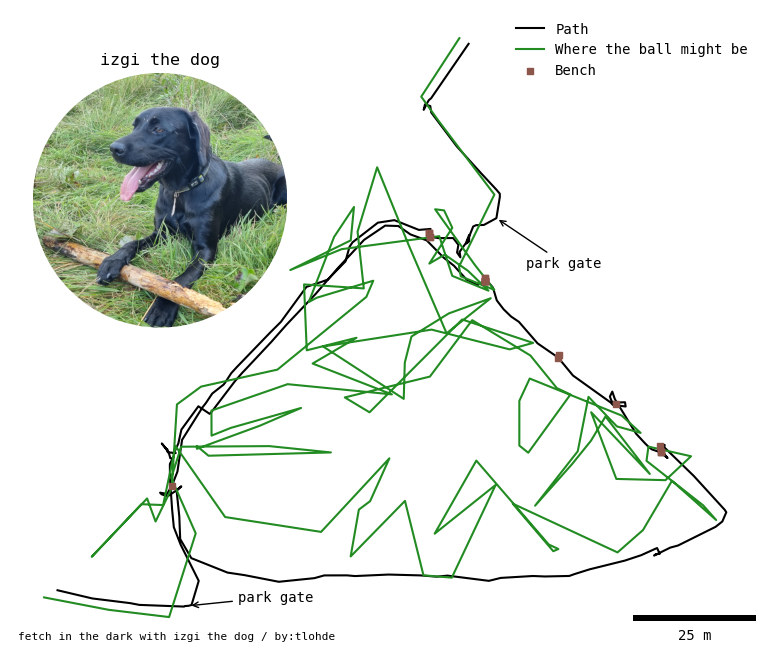

In [ ]:
with plt.rc_context({'font.family':'monospace'}):
    fig, ax = plt.subplots(figsize=[11.69, 8.27],
                        subplot_kw={'aspect':'equal'})

    # plot points as line
    geoms = me['geometry'].tolist()
    ax.plot(*LineString(geoms).coords.xy,
            color='k',
            label='Path',
            zorder=0)

    geoms = i['geometry'].tolist()
    ax.plot(*LineString(geoms).coords.xy,
            color='forestgreen',
            label='Where the ball might be',
            zorder=0)

    # use speed and dx thresholds to identify where i stopped
    # which was generally at the benches
    me.loc[(me['v'] < 0.07) & (me['dx'] < 0.27)].plot(ax=ax,
                                                    label='Bench',
                                                    color='tab:brown',
                                                    marker='s',
                                                    zorder=1,
                                                    markersize=20)

    ax.legend(frameon=False, loc='upper right')
    ax.add_artist(ScaleBar(1, location='lower right'))
    ax.set_axis_off()

    ax.annotate('park gate',
                xy=(me.iloc[6]['geometry'].x, me.iloc[6]['geometry'].y),
                xytext=(me.iloc[6]['geometry'].x + 10, me.iloc[6]['geometry'].y + 1),
                arrowprops={'arrowstyle':'->'})

    ax.annotate('park gate',
                xy=(me.iloc[-15]['geometry'].x,me.iloc[-15]['geometry'].y),
                xytext=(me.iloc[-15]['geometry'].x + 6, me.iloc[-15]['geometry'].y - 10),
                arrowprops={'arrowstyle':'->'})

    ax.annotate('fetch in the dark with izgi the dog / by:tlohde',
                xy=(0.01, 0.01),
                xycoords='axes fraction',
                ha='left', 
                fontsize=8)
    
    # add inset axes and image
    img_ax = ax.inset_axes([0, 0.5, 0.4, 0.4])
    im = img_ax.imshow(img)
    img_ax.set_xlim(1000, 3000)
    img_ax.set_ylim(2000, 0)

    patch = patches.Circle((2000, 1000), 1000,
                           transform=img_ax.transData)
    im.set_clip_path(patch)
    img_ax.set_axis_off()
    img_ax.set_title('izgi the dog')
    
    # fig.savefig('day17.jpg', dpi=300, bbox_inches='tight')